Here we set the model to run using CPU. By doing this we can inspect the model using the CPU while we train another using the GPU.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
# from PIL import Image
from functools import reduce
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE

In [3]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Load model

In [47]:
encoder = tf.keras.models.load_model('./vae_encoder_keras_model_200.hdf5')
decoder = tf.keras.models.load_model('./vae_decoder_keras_model_200.hdf5')

In [9]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 13, 13, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

#### latent model

In [9]:
# input_img = autoencoder.get_layer('input_2').output
# encoded = autoencoder.get_layer('max_pooling2d_10').output
input_img = autoencoder.get_layer('input_1').output
encoded = autoencoder.get_layer('max_pooling2d_1').output
latent_model = Model(input_img, encoded)

In [10]:
input_img.shape

TensorShape([None, 28, 28, 1])

In [19]:
preds = encoder.predict(x_test[0:2,:,:,:])

In [11]:
_, IMG_HEIGHT, IMG_WIDTH, _ = input_img.shape
IMG_HEIGHT, IMG_WIDTH

(28, 28)

In [21]:
# def plot_latents(input_image):
# #     test_im = Image.open(input_image).convert('RGB')
# #     test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))a
# #     test_ar = np.asarray(test_im) / 255
# #     test_ar = np.expand_dims(test_ar,0)
#     test_ar = input_image
#     pred = autoencoder.predict(test_ar)
    
#     for real, coded in zip(test_ar, pred):
#         plt.figure(figsize = (2,4))
#         plt.subplot(1,2,1)
#         plt.imshow(real[:,:,0])
#         plt.subplot(1,2,2)
#         plt.imshow(coded[:,:,0])   
    
#     coded_image = latent_model.predict(test_ar)
#     coded_dims = coded_image.shape[-1]

#     plt.figure(figsize = (5,3))
#     for i in range(coded_dims):
#         plt.subplot(int(np.ceil(coded_dims)/4),4, i+1)
#         plt.imshow(coded_image[0, :, :, i])
#     plt.tight_layout()    
    
#     return pred, coded_image

# _ ,_ = plot_latents(x_test[0:1,:,:,:])

### Latent space representation

In [22]:
import seaborn as sns
from sklearn.metrics import silhouette_score

__SCORE__: mean Silhouette Coefficient

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

> The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [23]:
real_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(np.vstack([np.ravel(tim) for tim in x_test]))
real_data = pd.DataFrame({
        'x': real_tsne[:, 0],
        'y': real_tsne[:, 1],
        'label': y_test})

score: 0.3633441925048828


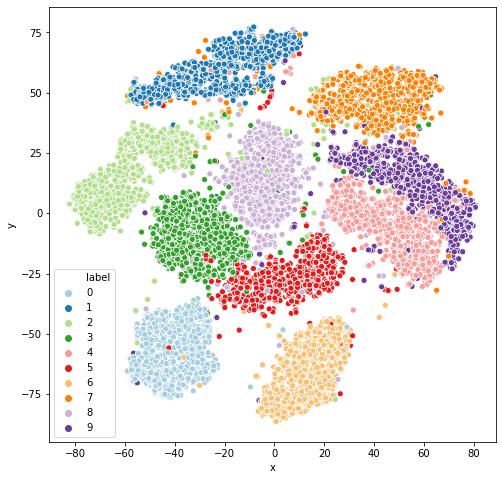

In [24]:
print('score: {}'.format(silhouette_score(real_tsne, real_data['label'] )))
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='x', y='y', hue='label', data=real_data, palette='Paired')

#### latent space

In [34]:
latents = encoder.predict(x_test)
latent_mu, latent_var, latent_z = latents[0], latents[1], latents[2]

In [39]:
latents_tsnes = {}
for data, who in zip(latents, ['mu', 'var', 'z']):
    print(who)
    latent_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(data)
    latent_df = pd.DataFrame({
            'x': latent_tsne[:, 0],
            'y': latent_tsne[:, 1],
            'label': y_test})
    latents_tsnes[who] = latent_df

mu
var
z


mu
score: 0.4637690484523773
var
score: 0.2759281098842621
z
score: -0.11624885350465775


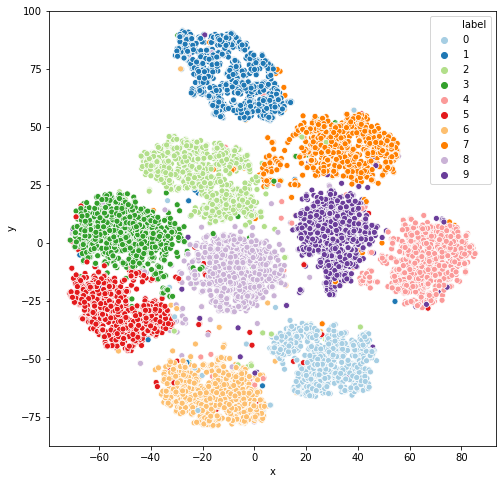

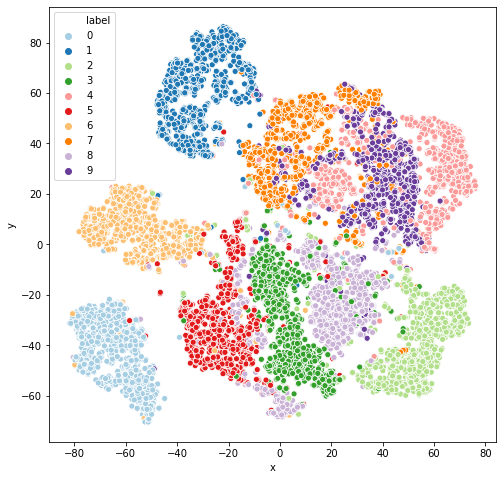

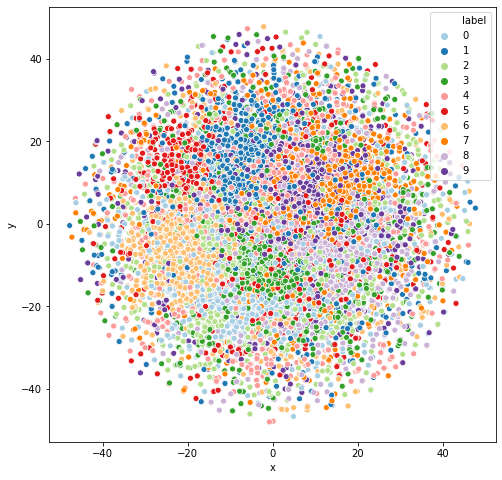

In [46]:
for which in ['mu', 'var', 'z']:
    print(which)
    latent_data = latents_tsnes[which]
    print('score: {}'.format(silhouette_score(latent_data[['x', 'y']].values, latent_data['label'].values )))
    fig = plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')

[[-0.39565474 -0.19682871 -0.89302285  0.51619937  0.50507169 -0.68013658
   0.13761377 -1.56980463 -0.71281371  0.31383493 -0.79081635  1.50411026
  -1.01188068 -0.13230989  0.49873025  0.18305723 -1.39670276  0.49204741
  -1.39907942 -0.56560738 -0.73230995  1.110715   -1.13336309 -0.76464512
   1.28791076  0.63060092  0.59340222  0.36488763  1.00634508  0.4305262
  -0.05581787  0.02103004  2.09617799 -0.90923461 -0.08951443  0.88491579
  -0.31761462 -0.96043177 -0.25907564 -1.19366818  0.34598332  0.67747952
  -0.92260531 -1.20750599  1.42481663  1.85525126  3.29343831 -1.51891933
   0.19328872  2.86784744]]


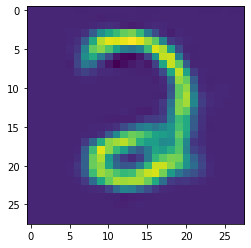

In [49]:
# z_sample = np.zeros(50, )
# z_sample[0] = -5
# z_sample[20] = 4
# z_sample = np.reshape(z_sample, (1,50))
z_sample = np.random.randn((50))
z_sample = np.reshape(z_sample, (1,50))
im_sample = decoder.predict(z_sample)

print(z_sample)
plt.figure()
plt.imshow(im_sample[0,:,:,0])